In [1]:
import polars as pl
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from xgboost import XGBRegressor, XGBClassifier

import sys
sys.path.append("/Users/leon/Desktop/kaggle")
from src.rainfall.transformer_impl import RainfallTransformer as RT

array([[<Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'pressure'}>,
        <Axes: title={'center': 'maxtemp'}>],
       [<Axes: title={'center': 'temparature'}>,
        <Axes: title={'center': 'mintemp'}>,
        <Axes: title={'center': 'dewpoint'}>],
       [<Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'cloud'}>,
        <Axes: title={'center': 'sunshine'}>],
       [<Axes: title={'center': 'winddirection'}>,
        <Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'rainfall'}>]], dtype=object)

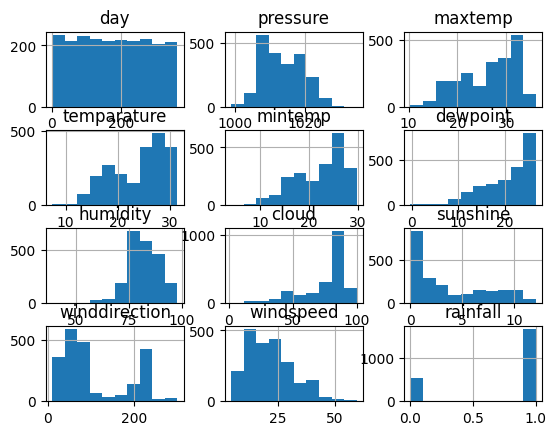

In [2]:
df = pl.read_csv("./data/train.csv")
df.select(pl.exclude("id")).to_pandas().hist()

In [3]:
df.describe()

statistic,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0,2190.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1094.5,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.03653,75.721918,3.744429,104.863151,21.804703,0.753425
"""std""",632.342866,105.203592,5.655366,5.65433,5.22241,5.05912,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
"""min""",0.0,1.0,999.0,10.4,7.4,4.0,-0.3,39.0,2.0,0.0,10.0,4.4,0.0
"""25%""",547.0,89.0,1008.6,21.3,19.3,17.7,16.8,77.0,69.0,0.4,40.0,14.1,1.0
"""50%""",1095.0,179.0,1013.0,27.8,25.5,23.9,22.2,82.0,83.0,2.4,70.0,20.5,1.0
"""75%""",1642.0,270.0,1017.8,31.2,28.4,26.4,25.0,88.0,88.0,6.8,200.0,27.9,1.0
"""max""",2189.0,365.0,1034.6,36.0,31.5,29.8,26.7,98.0,100.0,12.1,300.0,59.5,1.0


In [4]:
df.select(pl.col("rainfall")).null_count()

rainfall
u32
0


array([[<Axes: xlabel='sunshine', ylabel='sunshine'>,
        <Axes: xlabel='temparature', ylabel='sunshine'>],
       [<Axes: xlabel='sunshine', ylabel='temparature'>,
        <Axes: xlabel='temparature', ylabel='temparature'>]], dtype=object)

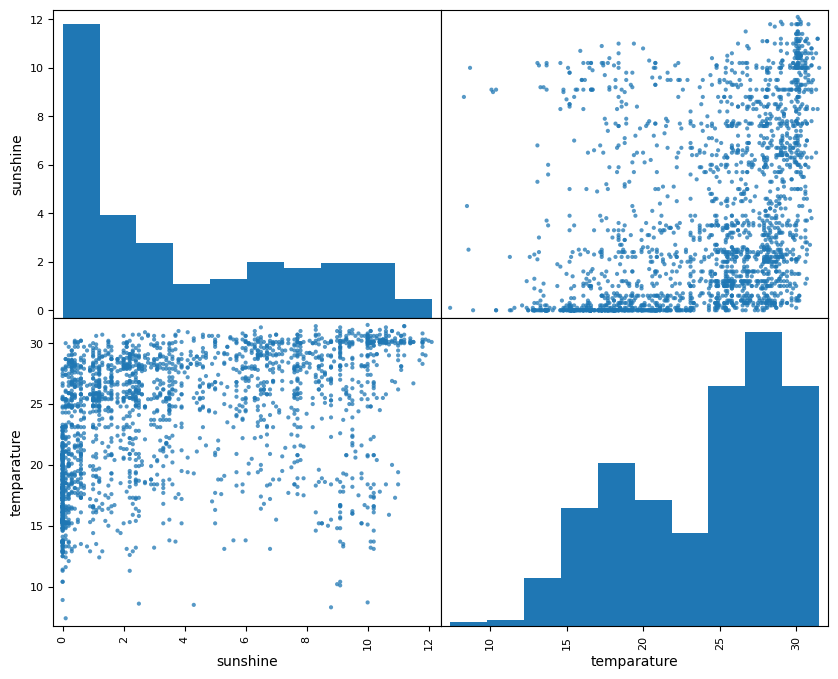

In [5]:
from pandas.plotting import scatter_matrix
scatter_matrix(df.select(pl.col(["sunshine", "temparature"])).to_pandas(), figsize=(10, 8), alpha=0.75)

# Learnings
## General
- model to use: **binary classifier**
## Data Interdependencies
- maxtemp, temperature & mintemp are very closely related
  **-> pca to reduce model complexity**
- maxtemp, temperature, mintemp & pressure are cyclical
- maxtemp, temperature & mintemp are inversely related to pressure.
## Lags
- 1d lag for humidity
- 1d, 1w, 1y, 2y lag for rainfall
## Additional Variables
- days since last rained?
## Reduce Complexity

In [6]:
rt = RT()
data = rt.transform(df)
X = data[:, :-1]
y = data[:, -1].ravel()
data

['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'rainfall_lag_1d', 'rainfall_lag_1w', 'rainfall_lag_1y', 'rainfall_lag_2y', 'humidity_lag_1d', 'rainfall']
[1. 1. 1. ... 1. 1. 1.]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


array([[0.00000000e+00, 5.16853933e-01, 4.21875000e-01, ...,
        1.00000000e+00, 7.28813559e-01, 1.00000000e+00],
       [4.56829603e-04, 5.75842697e-01, 2.26562500e-01, ...,
        1.00000000e+00, 8.13559322e-01, 1.00000000e+00],
       [9.13659205e-04, 7.05056180e-01, 3.51562500e-01, ...,
        1.00000000e+00, 9.49152542e-01, 1.00000000e+00],
       ...,
       [9.99086341e-01, 4.01685393e-01, 3.35937500e-01, ...,
        1.00000000e+00, 8.81355932e-01, 1.00000000e+00],
       [9.99543170e-01, 6.54494382e-01, 2.34375000e-01, ...,
        1.00000000e+00, 6.77966102e-01, 1.00000000e+00],
       [1.00000000e+00, 4.15730337e-01, 4.21875000e-01, ...,
        1.00000000e+00, 8.98305085e-01, 1.00000000e+00]])

In [7]:
sss = ms.StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=42)
for train_index, eval_index in sss.split(X, y):
	X_train, X_eval = X[train_index], X[eval_index]
	y_train, y_eval = y[train_index], y[eval_index]

	xgb_clf = XGBClassifier(
		device="cuda",
		max_depth=6,
		colsample_bytree=0.9,
		subsample=0.9,
		n_estimators=10_000,
		learning_rate=0.1,
		eval_metric="auc",
		early_stopping_rounds=1000,
		alpha=1,
	).fit(X_train, y_train, eval_set=[(X_eval, y_eval)])


[0]	validation_0-auc:0.85589
[1]	validation_0-auc:0.87660
[2]	validation_0-auc:0.87492
[3]	validation_0-auc:0.86807
[4]	validation_0-auc:0.86818
[5]	validation_0-auc:0.86543
[6]	validation_0-auc:0.86582
[7]	validation_0-auc:0.86554
[8]	validation_0-auc:0.86655
[9]	validation_0-auc:0.86038
[10]	validation_0-auc:0.86313
[11]	validation_0-auc:0.86639
[12]	validation_0-auc:0.86863
[13]	validation_0-auc:0.86908
[14]	validation_0-auc:0.87172
[15]	validation_0-auc:0.87828
[16]	validation_0-auc:0.87722
[17]	validation_0-auc:0.87800
[18]	validation_0-auc:0.87576
[19]	validation_0-auc:0.87778
[20]	validation_0-auc:0.88092
[21]	validation_0-auc:0.88238
[22]	validation_0-auc:0.88418
[23]	validation_0-auc:0.88575
[24]	validation_0-auc:0.88440
[25]	validation_0-auc:0.88260
[26]	validation_0-auc:0.88227


/Users/leon/Desktop/kaggle/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:06:16] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[27]	validation_0-auc:0.87991
[28]	validation_0-auc:0.88092
[29]	validation_0-auc:0.88002
[30]	validation_0-auc:0.88036
[31]	validation_0-auc:0.87946
[32]	validation_0-auc:0.87733
[33]	validation_0-auc:0.87856
[34]	validation_0-auc:0.87688
[35]	validation_0-auc:0.87778
[36]	validation_0-auc:0.87710
[37]	validation_0-auc:0.87643
[38]	validation_0-auc:0.87475
[39]	validation_0-auc:0.87497
[40]	validation_0-auc:0.87576
[41]	validation_0-auc:0.87632
[42]	validation_0-auc:0.87666
[43]	validation_0-auc:0.87542
[44]	validation_0-auc:0.87441
[45]	validation_0-auc:0.87306
[46]	validation_0-auc:0.87205
[47]	validation_0-auc:0.87262
[48]	validation_0-auc:0.87318
[49]	validation_0-auc:0.87228
[50]	validation_0-auc:0.87149
[51]	validation_0-auc:0.87262
[52]	validation_0-auc:0.87475
[53]	validation_0-auc:0.87351
[54]	validation_0-auc:0.87340
[55]	validation_0-auc:0.87306
[56]	validation_0-auc:0.87329
[57]	validation_0-auc:0.87306
[58]	validation_0-auc:0.87273
[59]	validation_0-auc:0.87385
[60]	valid

/Users/leon/Desktop/kaggle/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:06:21] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[40]	validation_0-auc:0.82985
[41]	validation_0-auc:0.83143
[42]	validation_0-auc:0.83232
[43]	validation_0-auc:0.82840
[44]	validation_0-auc:0.82772
[45]	validation_0-auc:0.82727
[46]	validation_0-auc:0.82738
[47]	validation_0-auc:0.82840
[48]	validation_0-auc:0.82907
[49]	validation_0-auc:0.82806
[50]	validation_0-auc:0.82884
[51]	validation_0-auc:0.82963
[52]	validation_0-auc:0.82851
[53]	validation_0-auc:0.82963
[54]	validation_0-auc:0.82997
[55]	validation_0-auc:0.82952
[56]	validation_0-auc:0.82952
[57]	validation_0-auc:0.82907
[58]	validation_0-auc:0.82974
[59]	validation_0-auc:0.83075
[60]	validation_0-auc:0.83098
[61]	validation_0-auc:0.83244
[62]	validation_0-auc:0.83075
[63]	validation_0-auc:0.82918
[64]	validation_0-auc:0.82772
[65]	validation_0-auc:0.82727
[66]	validation_0-auc:0.82873
[67]	validation_0-auc:0.82851
[68]	validation_0-auc:0.82694
[69]	validation_0-auc:0.82840
[70]	validation_0-auc:0.82750
[71]	validation_0-auc:0.82828
[72]	validation_0-auc:0.83053
[73]	valid

/Users/leon/Desktop/kaggle/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:06:29] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[36]	validation_0-auc:0.90404
[37]	validation_0-auc:0.90561
[38]	validation_0-auc:0.90595
[39]	validation_0-auc:0.90629
[40]	validation_0-auc:0.90550
[41]	validation_0-auc:0.90561
[42]	validation_0-auc:0.90494
[43]	validation_0-auc:0.90202
[44]	validation_0-auc:0.90157
[45]	validation_0-auc:0.90079
[46]	validation_0-auc:0.90034
[47]	validation_0-auc:0.90034
[48]	validation_0-auc:0.89978
[49]	validation_0-auc:0.90011
[50]	validation_0-auc:0.89944
[51]	validation_0-auc:0.89944
[52]	validation_0-auc:0.89978
[53]	validation_0-auc:0.89877
[54]	validation_0-auc:0.89843
[55]	validation_0-auc:0.89921
[56]	validation_0-auc:0.89865
[57]	validation_0-auc:0.89843
[58]	validation_0-auc:0.89843
[59]	validation_0-auc:0.89843
[60]	validation_0-auc:0.89854
[61]	validation_0-auc:0.89955
[62]	validation_0-auc:0.89832
[63]	validation_0-auc:0.89753
[64]	validation_0-auc:0.89652
[65]	validation_0-auc:0.89607
[66]	validation_0-auc:0.89686
[67]	validation_0-auc:0.89686
[68]	validation_0-auc:0.89697
[69]	valid

/Users/leon/Desktop/kaggle/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:06:34] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[43]	validation_0-auc:0.90393
[44]	validation_0-auc:0.90382
[45]	validation_0-auc:0.90370
[46]	validation_0-auc:0.90471
[47]	validation_0-auc:0.90561
[48]	validation_0-auc:0.90483
[49]	validation_0-auc:0.90337
[50]	validation_0-auc:0.90382
[51]	validation_0-auc:0.90247
[52]	validation_0-auc:0.90224
[53]	validation_0-auc:0.90269
[54]	validation_0-auc:0.90426
[55]	validation_0-auc:0.90370
[56]	validation_0-auc:0.90224
[57]	validation_0-auc:0.90303
[58]	validation_0-auc:0.90370
[59]	validation_0-auc:0.90505
[60]	validation_0-auc:0.90606
[61]	validation_0-auc:0.90617
[62]	validation_0-auc:0.90584
[63]	validation_0-auc:0.90584
[64]	validation_0-auc:0.90617
[65]	validation_0-auc:0.90595
[66]	validation_0-auc:0.90617
[67]	validation_0-auc:0.90494
[68]	validation_0-auc:0.90629
[69]	validation_0-auc:0.90640
[70]	validation_0-auc:0.90606
[71]	validation_0-auc:0.90617
[72]	validation_0-auc:0.90707
[73]	validation_0-auc:0.90752
[74]	validation_0-auc:0.90752
[75]	validation_0-auc:0.90864
[76]	valid

/Users/leon/Desktop/kaggle/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:06:40] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[37]	validation_0-auc:0.92851
[38]	validation_0-auc:0.92873
[39]	validation_0-auc:0.92873
[40]	validation_0-auc:0.92873
[41]	validation_0-auc:0.93030
[42]	validation_0-auc:0.93187
[43]	validation_0-auc:0.93277
[44]	validation_0-auc:0.93401
[45]	validation_0-auc:0.93356
[46]	validation_0-auc:0.93333
[47]	validation_0-auc:0.93210
[48]	validation_0-auc:0.93187
[49]	validation_0-auc:0.93266
[50]	validation_0-auc:0.93221
[51]	validation_0-auc:0.93154
[52]	validation_0-auc:0.93221
[53]	validation_0-auc:0.93232
[54]	validation_0-auc:0.93154
[55]	validation_0-auc:0.93187
[56]	validation_0-auc:0.92929
[57]	validation_0-auc:0.92997
[58]	validation_0-auc:0.93176
[59]	validation_0-auc:0.93176
[60]	validation_0-auc:0.93221
[61]	validation_0-auc:0.93244
[62]	validation_0-auc:0.93154
[63]	validation_0-auc:0.93232
[64]	validation_0-auc:0.93154
[65]	validation_0-auc:0.93120
[66]	validation_0-auc:0.93277
[67]	validation_0-auc:0.93232
[68]	validation_0-auc:0.93221
[69]	validation_0-auc:0.93277
[70]	valid

In [8]:
xgb_clf.feature_importances_

array([0.04014068, 0.0382862 , 0.05205531, 0.05525931, 0.04829451,
       0.05775276, 0.3409321 , 0.08605008, 0.04138276, 0.03950891,
       0.05750147, 0.03559349, 0.02657757, 0.03988603, 0.04077879],
      dtype=float32)